# Fountain calling with Chromosight

Chromosight is a tools for pattern calling that takes a binary mask as an input and correltaes Hi-C maps with this mask:

<a name="ref4" href="https://doi.org/10.1038/s41467-020-19562-7">Matthey-Doret, C., Baudry, L., Breuer, A., Montagne, R., Guiglielmoni, N., Scolari, V., ... & Cournac, A. (2020). 
   Computer vision for pattern detection in chromosome contact maps. 
   Nature Communications, 11(1), 1-11.</a>
   
In this notebook, we compare the results of fontanka output with Chromosight, and demonstrate that patterns called with Chromosight have sharp edges and generally perform not as good for picking up reference fountains. 

In [1]:
# Download the data:
! mkdir -p data/cool/

! wget https://osf.io/u3p8q/download -O data/danRer11.arms.viewframe.tsv # chromosomal arm annotation (manual markup)
! wget https://osf.io/edra2/download -O data/WT-manually-called-foutnains.bed # manually called fountains
! wget https://osf.io/u9jpy/download -O data/good-bins.50000-safe.danrer11-reduced.tsv # Annotation of good bins
! wget https://osf.io/9qj27/download -O data/WT.avfountain.npy # Average fountain based on manually called ones

# The following downloads will be updated with the release of the paper: 
! wget ${} -O data/cool/WT.danrer11-reduced.mapq_30.1000.mcool # Download Wild-Type 5.3 hpf Hi-C maps for Danio rerio
! wget ${} -O data/cool/WT1.danrer11-reduced.mapq_30.1000.mcool # Download Wild-Type 5.3 hpf Hi-C maps for Danio rerio, rep 1
! wget ${} -O data/cool/WT2.danrer11-reduced.mapq_30.1000.mcool # Download Wild-Type 5.3 hpf Hi-C maps for Danio rerio, rep 2

## 1. Define patterns masks and run Chromosight 

In [ ]:
!pip install chromosight # installed version is 1.6.3

### 1.a. Default Chromosight hairpin pattern

In [1]:
import chromosight.kernels as ck
kernel_hairpin = ck.hairpins['kernels'][0]

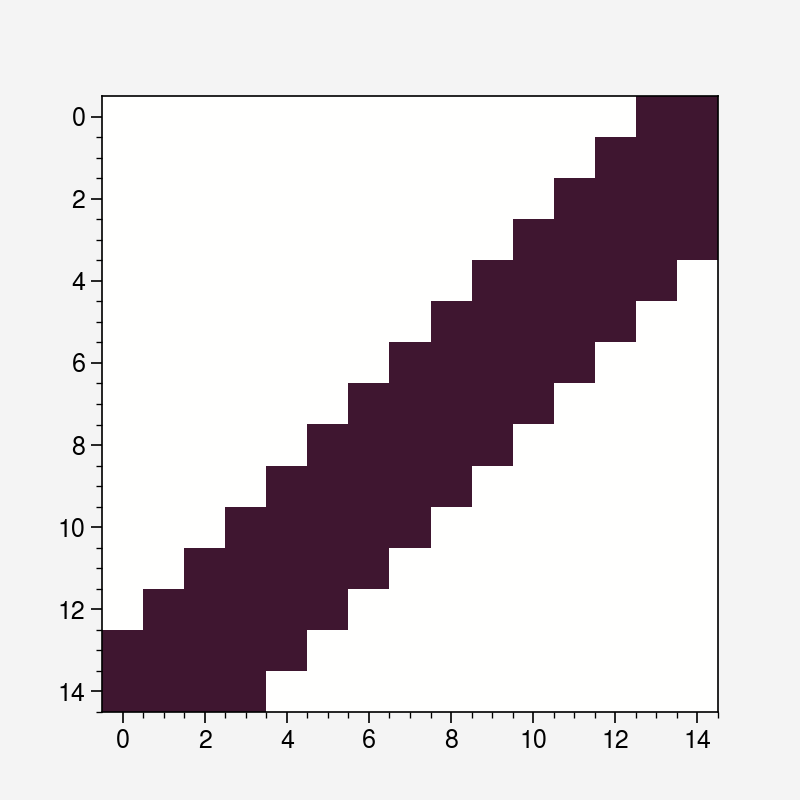

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import fontanka # for visualization imports

import warnings
warnings.filterwarnings('ignore')

plt.imshow(kernel_hairpin)

### 1.b. Custom binary fountains pattern

In [3]:
import numpy as np
from fontanka import inverted_trinagle_mask

In [4]:
kernel_offset = 20 # offset from the center to one side)

kernel_fragment = inverted_trinagle_mask(np.pi/4, kernel_offset, fill_pos=1.75, fill_neg=0.5, norm_sum=False)
kernel_fountain_even = np.vstack([
    np.hstack([np.ones([kernel_offset, kernel_offset])*0.5, kernel_fragment]),
    np.hstack([np.flip(kernel_fragment), np.ones([kernel_offset, kernel_offset])*0.5])    
])

kernel_fountain_odd = 0.5*np.ones([2*kernel_offset+1, 2*kernel_offset+1])

# Fill in upper triangle
idx2 = np.triu_indices(2*kernel_offset+1, 1)
idx1 = np.triu_indices(2*kernel_offset, 0)
kernel_fountain_odd[idx2] = kernel_fountain_even[idx1]

# Fill in lower triangle
idx2 = np.tril_indices(2*kernel_offset+1, -1)
idx1 = np.tril_indices(2*kernel_offset, 0)
kernel_fountain_odd[idx2] = kernel_fountain_even[idx1]

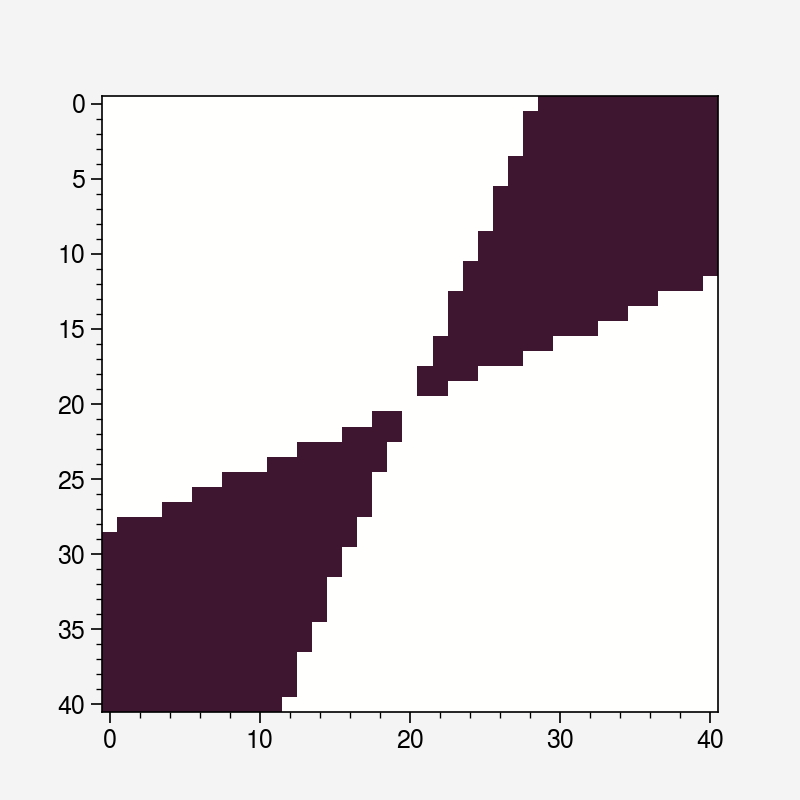

In [5]:
plt.imshow(kernel_fountain_odd)
plt.show()

In [7]:
kernel_hairpin.shape, kernel_fountain_odd.shape

((15, 15), (41, 41))

Save the resulting kernel: 

In [32]:
!mkdir -p data/chromosight/

In [8]:
# Save pattern
np.savetxt('data/chromosight/pattern_fountain.offset20.txt', kernel_fountain_odd, fmt='%.18e', delimiter=' ')

In [9]:
# Create json files, only the kernels are changes, all the rest is inherited from default hairpins calling:
with open('data/chromosight/pattern_fountain.offset20.json', 'w') as f:
    f.write("""{
    "name": "hairpins",
    "kernels": [
        "pattern_fountain.offset20.txt"
    ],
    "max_dist": 0,
    "min_dist": 0,
    "max_iterations": 1,
    "max_perc_zero": 10.0,
    "max_perc_undetected": 75.0,
    "min_separation": 2,
    "pearson": 0.1,
    "resolution": 10000
}""")

### Run Chromosight

In [ ]:
%%bash
# Detect hairpins: 
chromosight detect ./data/cool/WT.danrer11-reduced.mapq_30.1000.mcool::/resolutions/10000 data/chromosight/WT.chromosight-output.default \
  --threads 10 -W 41 --pattern hairpins

# Detect fountains: 
chromosight detect ./data/cool/WT.danrer11-reduced.mapq_30.1000.mcool::/resolutions/10000 data/chromosight/WT.chromosight-output.fountains20 \
  --threads 10 -W 41 --kernel-config="./data/chromosight/pattern_fountain.offset20.json"  

## Chromosight output and average pattern

In [10]:
# Load the chromosight annotation:
import pandas as pd

df_chromo_hairpin = pd.read_table('data/chromosight/WT.chromosight-output.default.tsv')
df_chromo_hairpin.columns = [x.strip('1') for x in df_chromo_hairpin.columns]

df_chromo_fountain = pd.read_table('data/chromosight/WT.chromosight-output.fountains20.tsv')
df_chromo_fountain.columns = [x.strip('1') for x in df_chromo_fountain.columns]

In [11]:
df_fontanka_output = pd.read_table('data/WT.fountains.fontanka.tsv') # Output of the notebook 00
df_fontanka_output = df_fontanka_output.drop(['index', 'Unnamed: 0'], axis=1)

df_manual_fountains = pd.read_table("./data/WT-manually-called-foutnains.bed", header=None)
df_manual_fountains.columns = ["chrom", "start", "end"]

In [12]:
import numpy as np
import cooler 
import bioframe
import fontanka

LABEL = "WT"
RESOLUTION = 10000

coolpath = f'./data/cool/{LABEL}.danrer11-reduced.mapq_30.1000.mcool::resolutions/{RESOLUTION}'
clr = cooler.Cooler(coolpath)
bins = clr.bins()[:]

stack = np.load("./data/snips/WT.200Kb.snips.npy")

In [16]:
# Fountain annotation with noise score and good bins: 
df_fountain_annotation = pd.read_table("data/WT.fountain-annotation.fontanka.tsv")

In [17]:
df_fountain_annotation.head()

Unnamed: 0.1  Unnamed: 0 chrom  start    end  window_start  window_end  FS  \
0             0           0  chr1      0  10000       -200000      210000 NaN   
1             1           1  chr1  10000  20000       -190000      220000 NaN   
2             2           2  chr1  20000  30000       -180000      230000 NaN   
3             3           3  chr1  30000  40000       -170000      240000 NaN   
4             4           4  chr1  40000  50000       -160000      250000 NaN   

   FS_peaks  Scharr_box  is_peak_prominent  is_FS_positive  is_good_bin  \
0       NaN         NaN              False           False         True   
1       NaN         NaN              False           False         True   
2       NaN         NaN              False           False         True   
3       NaN         NaN              False           False         True   
4       NaN         NaN              False           False         True   

   is_not_noisy  
0         False  
1         False  
2         False  
3         False  
4         False

Text(0.5, 0.98, 'Fountain calling output')

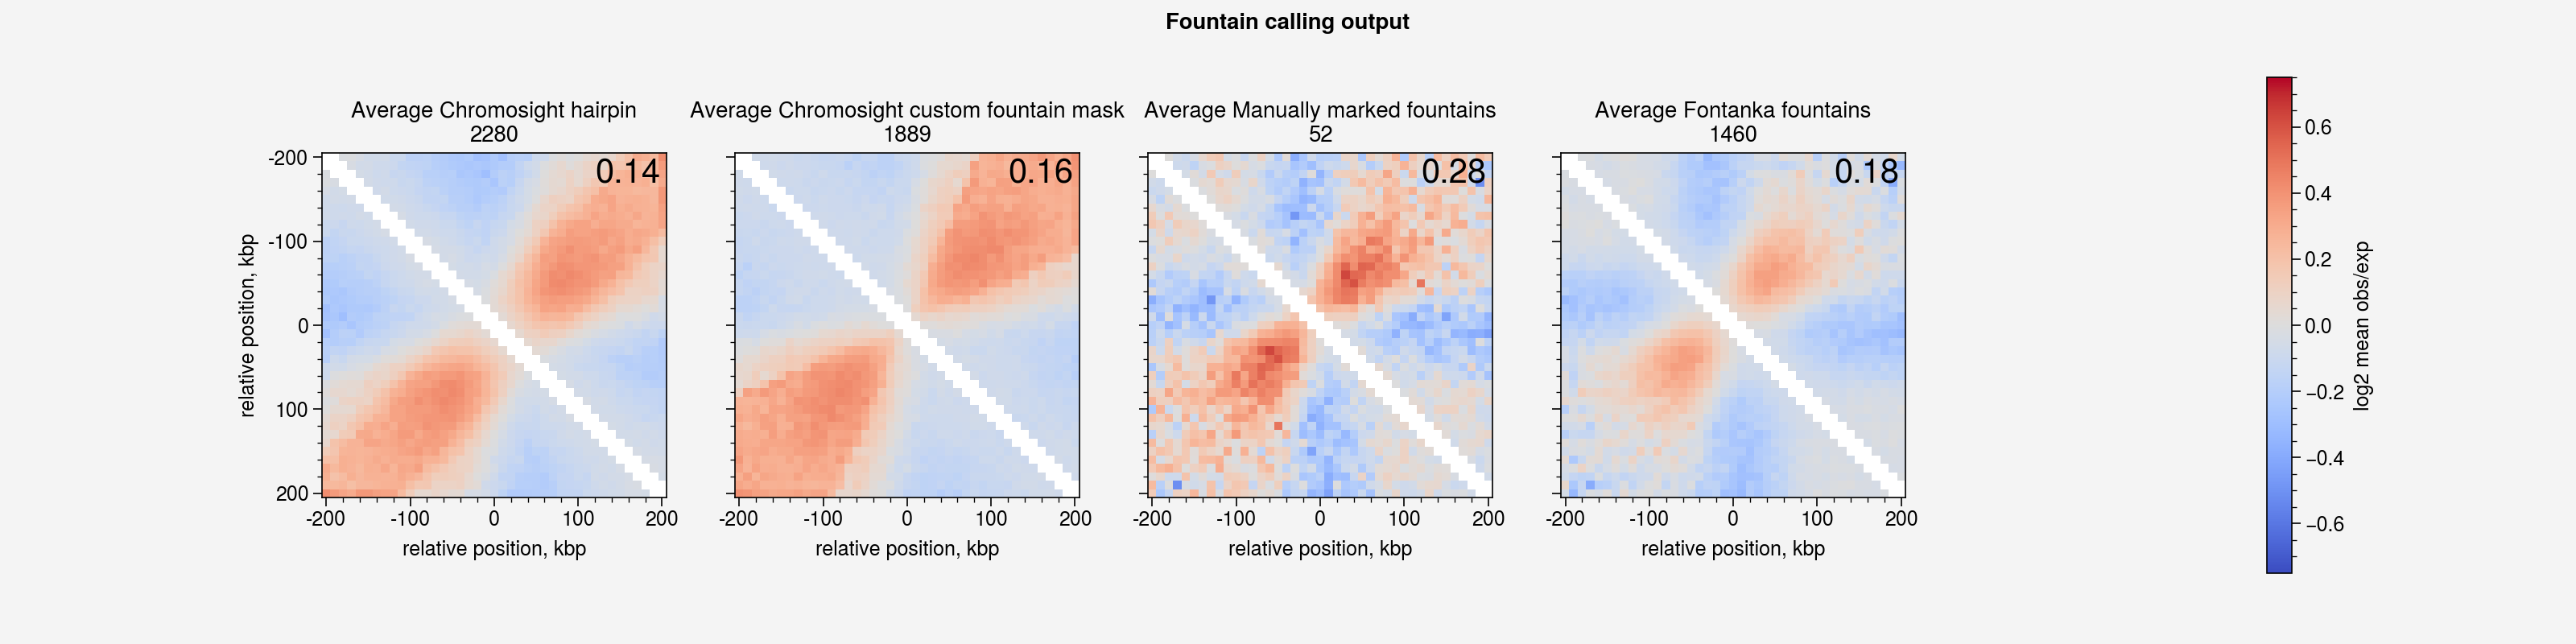

In [22]:
# Plot average patterns: 
FLANK = 200_000

fig, axes = plt.subplots(1, 5, figsize=[16, 4], sharey=True, sharex=True)
axes.flatten()[-1].set_axis_off()

for i, (df, title) in enumerate([
    (df_chromo_hairpin, "Chromosight hairpin"), 
    (df_chromo_fountain, "Chromosight custom fountain mask"),
    (df_manual_fountains, "Manually marked fountains"),
    (df_fontanka_output, "Fontanka fountains")
                 ]):
    bins_fountains = bioframe.overlap(bins, df).dropna(subset=["chrom_"])
    index_fountains = bins_fountains.index.values

    # Visualize fountain average: 
    pile = np.nanmean( stack[:, :, index_fountains], axis=2)
    pile = fontanka.reflect(pile)

    ax = axes.flatten()[i]
    im = ax.imshow(
        np.log2( pile ),
        vmax =  0.75,
        vmin = -0.75,
        cmap='coolwarm',
        interpolation=None)

    ticks_pixels = np.linspace(0, FLANK*2//RESOLUTION,5)
    ticks_kbp = ((ticks_pixels-ticks_pixels[-1]/2)*RESOLUTION//1000).astype(int)
    ax.set_xticks(ticks_pixels)
    ax.set_xticklabels(ticks_kbp)
    ax.set_xlabel('relative position, kbp')

    if i==0:
        ax.set_yticks(ticks_pixels)
        ax.set_yticklabels(ticks_kbp)
        ax.set_ylabel('relative position, kbp')

    score = np.nanmean(df_fountain_annotation.loc[index_fountains, 'FS'])
    ax.text(32.0, 0.0, f"{score:.2f}", 
        horizontalalignment='left', 
        verticalalignment='top', 
        fontsize=15)
    
    ax.set_title(f"Average {title}\n{len(index_fountains)}");
    
plt.colorbar(im, ax=axes.flatten()[-1], label = 'log2 mean obs/exp')
plt.suptitle("Fountain calling output")

The result for chromosight look very "artificial", as we usually see very abrupt edges of the patterns. 
As a sanity check, let's clean up the fountains that might come from very noisy regions: 

Text(0.5, 0.98, 'Fountain calling output, filtered by closeness to unmapped regions')

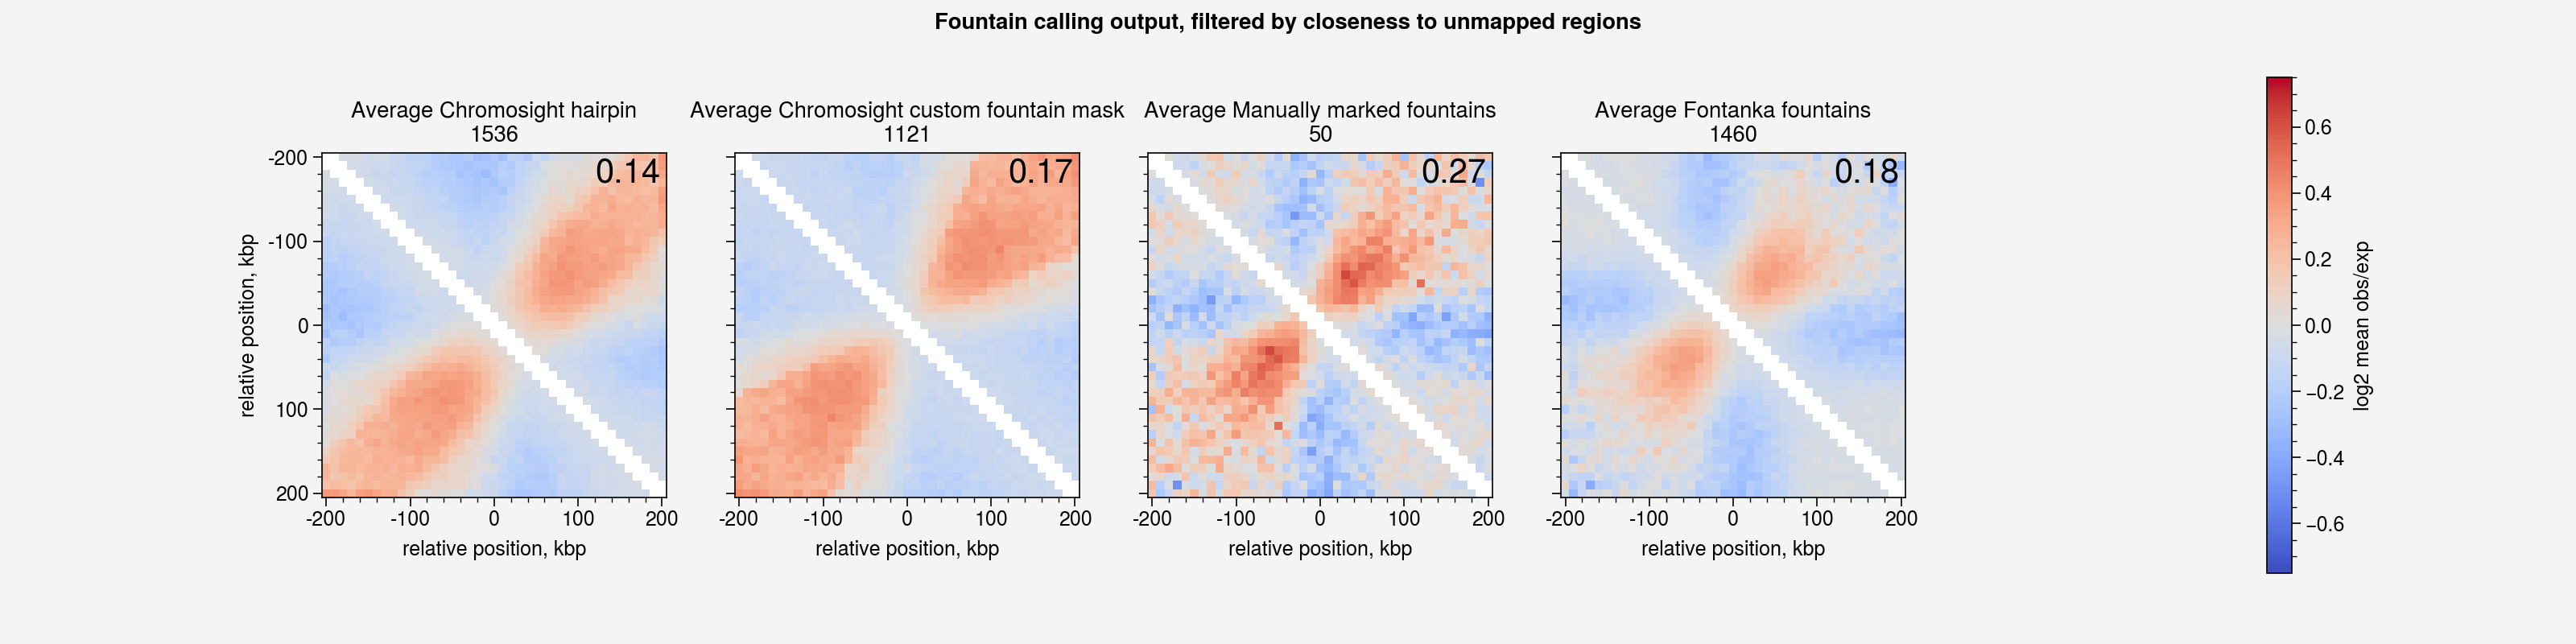

In [20]:
# Plot average patterns: 
FLANK = 200_000

fig, axes = plt.subplots(1, 5, figsize=[16, 4], sharey=True, sharex=True)
axes.flatten()[-1].set_axis_off()

for i, (df, title) in enumerate([
    (df_chromo_hairpin, "Chromosight hairpin"), 
    (df_chromo_fountain, "Chromosight custom fountain mask"),
    (df_manual_fountains, "Manually marked fountains"),
    (df_fontanka_output, "Fontanka fountains")
                 ]):
    
    df_overlapped = bioframe.overlap(df, df_fountain_annotation, how='left')
    df = df.loc[ df_overlapped.query('(is_good_bin_==True)').index, : ].copy()
    
    bins_fountains = bioframe.overlap(bins, df).dropna(subset=["chrom_"])
    index_fountains = bins_fountains.index.values

    # Visualize fountain average: 
    pile = np.nanmean( stack[:, :, index_fountains], axis=2)
    pile = fontanka.reflect(pile)

    ax = axes.flatten()[i]
    im = ax.imshow(
        np.log2( pile ),
        vmax =  0.75,
        vmin = -0.75,
        cmap='coolwarm',
        interpolation=None)

    ticks_pixels = np.linspace(0, FLANK*2//RESOLUTION,5)
    ticks_kbp = ((ticks_pixels-ticks_pixels[-1]/2)*RESOLUTION//1000).astype(int)
    ax.set_xticks(ticks_pixels)
    ax.set_xticklabels(ticks_kbp)
    ax.set_xlabel('relative position, kbp')

    if i==0:
        ax.set_yticks(ticks_pixels)
        ax.set_yticklabels(ticks_kbp)
        ax.set_ylabel('relative position, kbp')
        
    score = np.nanmean(df_fountain_annotation.loc[index_fountains, 'FS'])
    ax.text(32.0, 0.0, f"{score:.2f}", 
        horizontalalignment='left', 
        verticalalignment='top', 
        fontsize=15)

    ax.set_title(f"Average {title}\n{len(index_fountains)}");
    
plt.colorbar(im, ax=axes.flatten()[-1], label = 'log2 mean obs/exp')
plt.suptitle("Fountain calling output, filtered by closeness to unmapped regions")

Text(0.5, 0.98, 'Fountain calling output, filtered by noise score and closeness to unmapped regions')

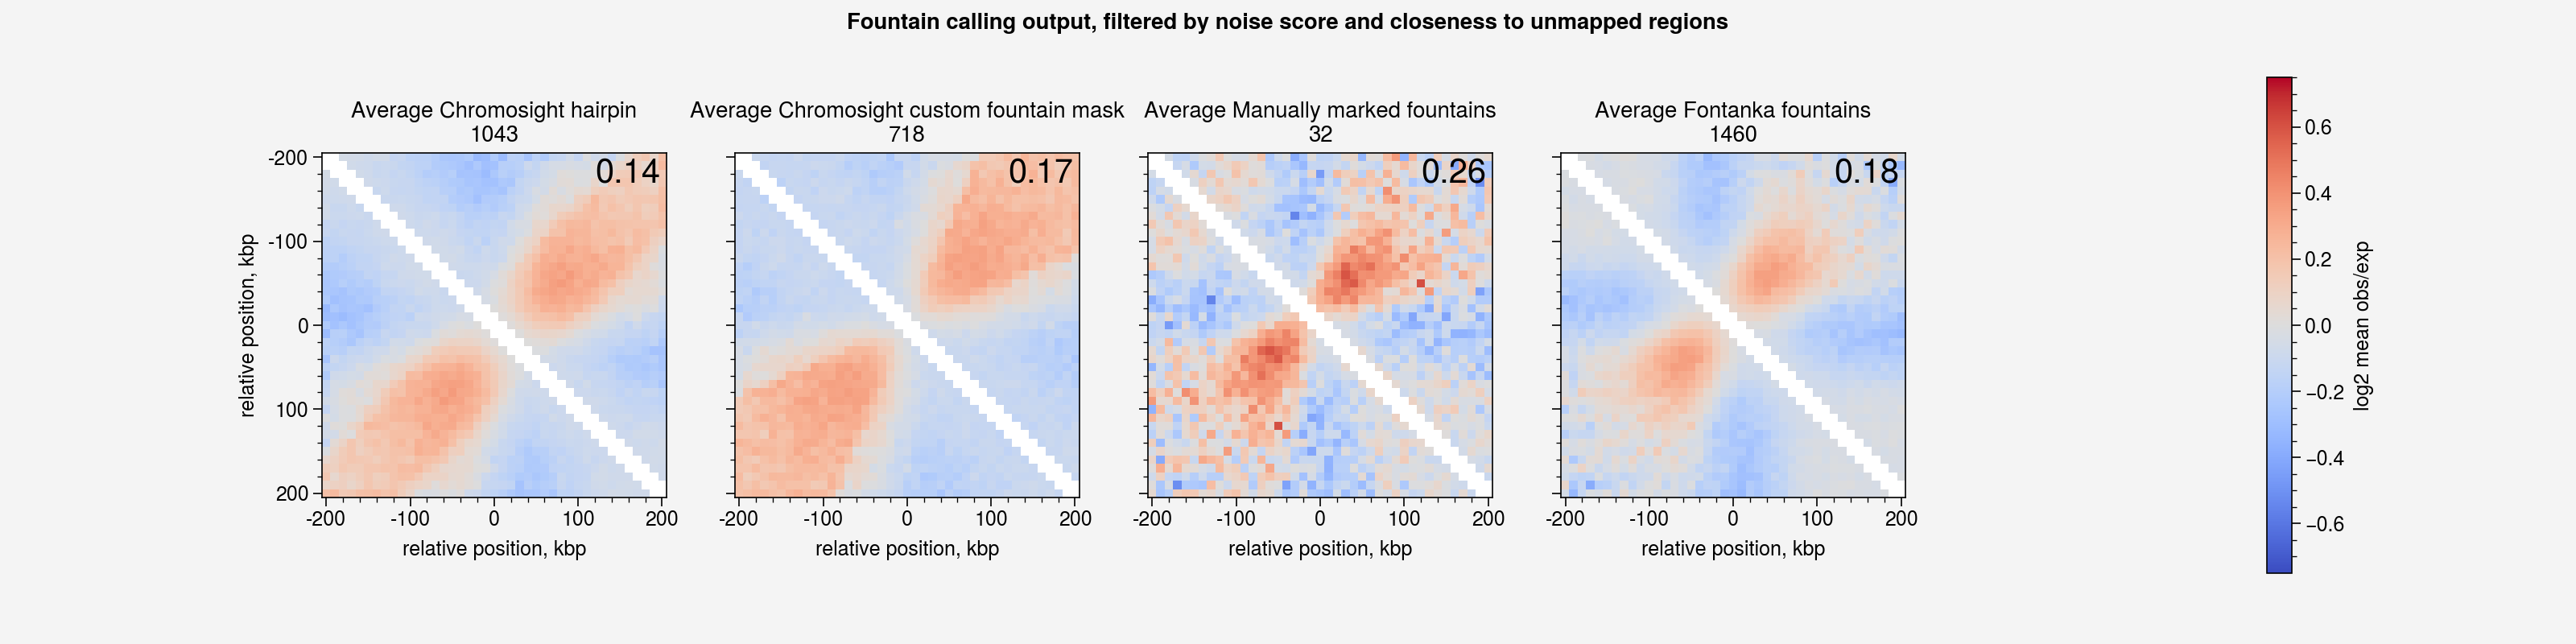

In [21]:
# Plot average patterns: 
FLANK = 200_000

fig, axes = plt.subplots(1, 5, figsize=[16, 4], sharey=True, sharex=True)
axes.flatten()[-1].set_axis_off()

for i, (df, title) in enumerate([
    (df_chromo_hairpin, "Chromosight hairpin"), 
    (df_chromo_fountain, "Chromosight custom fountain mask"),
    (df_manual_fountains, "Manually marked fountains"),
    (df_fontanka_output, "Fontanka fountains")
                 ]):
    
    df_overlapped = bioframe.overlap(df, df_fountain_annotation, how='left')
    df = df.loc[ df_overlapped.query('(is_good_bin_==True)&(is_not_noisy_==True)').index, : ].copy()
    
    bins_fountains = bioframe.overlap(bins, df).dropna(subset=["chrom_"])
    index_fountains = bins_fountains.index.values

    # Visualize fountain average: 
    pile = np.nanmean( stack[:, :, index_fountains], axis=2)
    pile = fontanka.reflect(pile)

    ax = axes.flatten()[i]
    im = ax.imshow(
        np.log2( pile ),
        vmax =  0.75,
        vmin = -0.75,
        cmap='coolwarm',
        interpolation=None)

    ticks_pixels = np.linspace(0, FLANK*2//RESOLUTION,5)
    ticks_kbp = ((ticks_pixels-ticks_pixels[-1]/2)*RESOLUTION//1000).astype(int)
    ax.set_xticks(ticks_pixels)
    ax.set_xticklabels(ticks_kbp)
    ax.set_xlabel('relative position, kbp')

    if i==0:
        ax.set_yticks(ticks_pixels)
        ax.set_yticklabels(ticks_kbp)
        ax.set_ylabel('relative position, kbp')

    score = np.nanmean(df_fountain_annotation.loc[index_fountains, 'FS'])
    ax.text(32.0, 0.0, f"{score:.2f}", 
        horizontalalignment='left', 
        verticalalignment='top', 
        fontsize=15)
    
    ax.set_title(f"Average {title}\n{len(index_fountains)}");
    
plt.colorbar(im, ax=axes.flatten()[-1], label = 'log2 mean obs/exp')
plt.suptitle("Fountain calling output, filtered by noise score and closeness to unmapped regions")

## Chromosight output and individual examples
As one can see from below, individual calls  by chromosight look like fountains, and it's hard to jusge whether it's much better than fontanka: 

In [158]:
# Examples of hairpin analysis:
df = df_chromo_hairpin.copy()
df_overlapped = bioframe.overlap(df, df_fountain_annotation, how='left')
df = df.loc[ df_overlapped.query('(is_good_bin_==True)&(is_not_noisy_==True)').index, : ].copy()

bins_fountains = bioframe.overlap(bins, df).dropna(subset=["chrom_"])
index_fountains = list(bins_fountains.sort_values('score_', ascending=False).index.values)

idx_selected = index_fountains[:100]
nrows = len(idx_selected)//10 # n_samples_show
ncols = 10

fig, axes = plt.subplots(nrows, ncols, figsize=[4*ncols, 4*nrows])

for i, idx in enumerate(idx_selected):
    
    ax = axes.flatten()[i]
    
    mtx = stack[:, :, idx]
    mtx = fontanka.reflect(mtx)

    img = ax.matshow(
        np.log2(mtx),  
        vmin=-1.75,
        vmax=1.75,
        cmap='coolwarm',
        interpolation=None
    );
    ax.xaxis.tick_bottom()
    if i > 0:
        ax.yaxis.set_visible(False)

    ax.xaxis.set_visible(False)
    
    ax.minorticks_off()
    reg = bins.loc[idx, ['chrom', 'start', 'end']]
    ax.set_title(f"{idx}\n{reg.chrom}:{reg.start}-{reg.end}");
    
    ticks_pixels = np.linspace(0, FLANK*2//RESOLUTION,5)
    ticks_kbp = ((ticks_pixels-ticks_pixels[-1]/2)*RESOLUTION//1000).astype(int)
    plt.xticks(ticks_pixels, ticks_kbp)
    plt.yticks(ticks_pixels, ticks_kbp)
    plt.xlabel('relative position, kbp')
    plt.ylabel('relative position, kbp')
    
plt.show();

In [159]:
# Examples of fountain mask analysis:
df = df_chromo_fountain.copy()
df_overlapped = bioframe.overlap(df, df_fountain_annotation, how='left')
df = df.loc[ df_overlapped.query('(is_good_bin_==True)&(is_not_noisy_==True)').index, : ].copy()

bins_fountains = bioframe.overlap(bins, df).dropna(subset=["chrom_"])
index_fountains = list(bins_fountains.sort_values('score_', ascending=False).index.values)

idx_selected = index_fountains[:100]
nrows = len(idx_selected)//10 # n_samples_show
ncols = 10

fig, axes = plt.subplots(nrows, ncols, figsize=[4*ncols, 4*nrows])

for i, idx in enumerate(idx_selected):
    
    ax = axes.flatten()[i]
    
    mtx = stack[:, :, idx]
    mtx = fontanka.reflect(mtx)

    img = ax.matshow(
        np.log2(mtx),  
        vmin=-1.75,
        vmax=1.75,
        cmap='coolwarm',
        interpolation=None
    );
    ax.xaxis.tick_bottom()
    if i > 0:
        ax.yaxis.set_visible(False)

    ax.xaxis.set_visible(False)
    
    ax.minorticks_off()
    reg = bins.loc[idx, ['chrom', 'start', 'end']]
    ax.set_title(f"{idx}\n{reg.chrom}:{reg.start}-{reg.end}");
    
    ticks_pixels = np.linspace(0, FLANK*2//RESOLUTION,5)
    ticks_kbp = ((ticks_pixels-ticks_pixels[-1]/2)*RESOLUTION//1000).astype(int)
    plt.xticks(ticks_pixels, ticks_kbp)
    plt.yticks(ticks_pixels, ticks_kbp)
    plt.xlabel('relative position, kbp')
    plt.ylabel('relative position, kbp')
    
plt.show();

## Chromosight: compare Chromosight output and reference fountains

Let's check how many manually marked fountains are detectable by chromosight call. 

### 1. Chromosight hairpin

In [142]:
import seaborn as sns

In [143]:
df = df_chromo_hairpin
df_overlapped = bioframe.overlap(df, df_fountain_annotation, how='left')
df = df.loc[ df_overlapped.query('(is_good_bin_==True)').index, : ].copy()

In [144]:
# Allowed offset to call a fountain a hit
offset = 2 * RESOLUTION

In [145]:
df_confirmed = bioframe.overlap( df_fountains_manual, 
                                bioframe.expand(df, offset), 
                                return_index=True, 
                                how='left' ).sort_values('score_').drop_duplicates('index').dropna(subset='chrom_')

Too little chromosight calls are marked as fountains manually: 

In [146]:
df_confirmed.groupby('chrom').count()['start']

chrom
chr1    9
chr2    7
Name: start, dtype: int64

In [147]:
df_fountains_manual.groupby('chrom').count()['start'] # Only one manual fountain was not detected as a peak

chrom
chr1    34
chr2    18
Name: start, dtype: int64

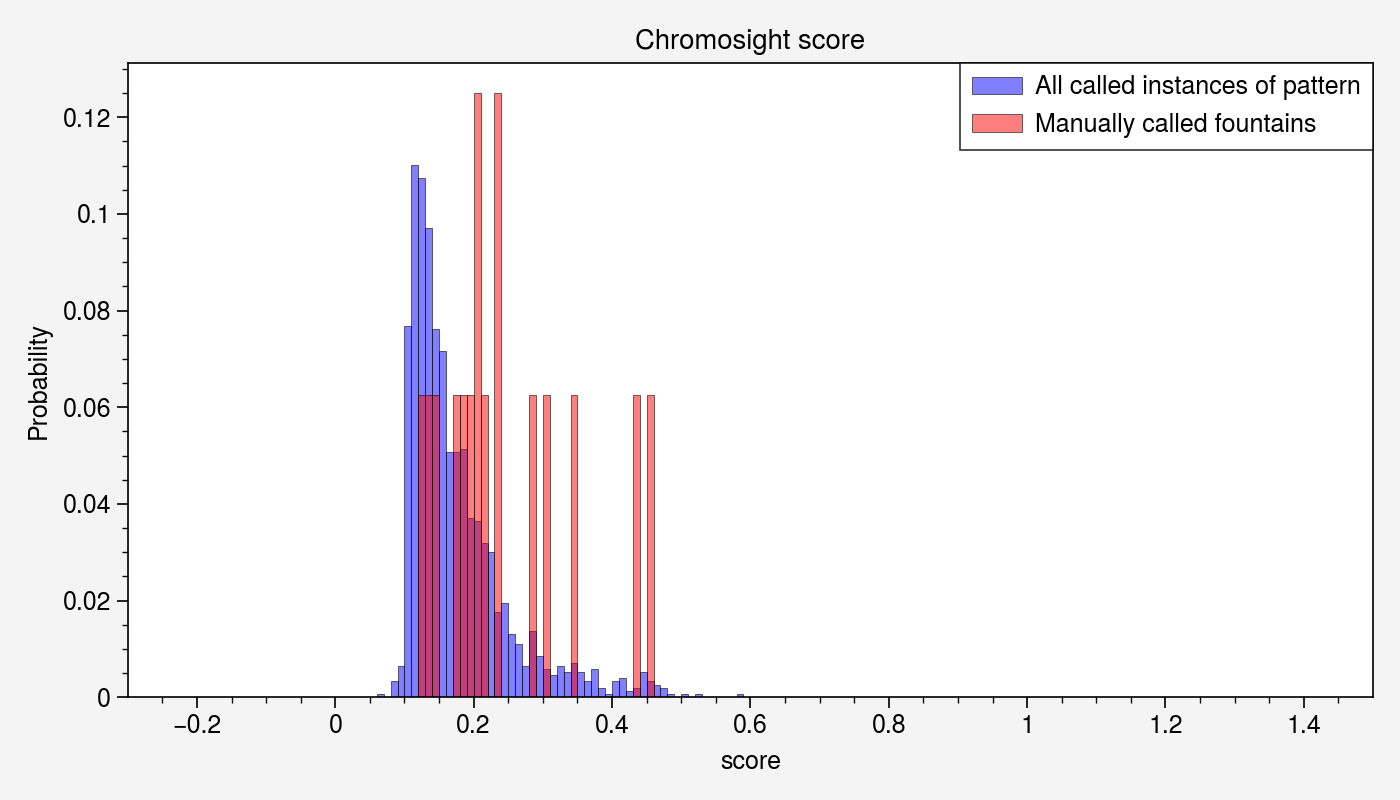

In [148]:
value = "score"
title = "Chromosight score"

plt.figure(figsize=[7, 4])

sns.histplot(df[value], 
             color='blue', alpha=0.5, stat='probability',
             bins=np.arange(-0.3, 1.5, 0.01), label='All called instances of pattern')

sns.histplot(df_confirmed[value+"_"], 
             color='red', alpha=0.5, stat='probability',
             bins=np.arange(-0.3, 1.5, 0.01), label='Manually called fountains')
plt.xlim(-0.3, 1.5)

plt.title(title)
plt.legend()
plt.tight_layout()

### 2. Chromosight fountain binary mask

In [149]:
df = df_chromo_fountain
df_overlapped = bioframe.overlap(df, df_fountain_annotation, how='left')
df = df.loc[ df_overlapped.query('(is_good_bin_==True)').index, : ].copy()

In [150]:
# Allowed offset to call a fountain a hit
offset = 2 * RESOLUTION

In [151]:
df_confirmed = bioframe.overlap( df_fountains_manual, 
                                bioframe.expand(df, offset), 
                                return_index=True, 
                                how='left' ).sort_values('score_').drop_duplicates('index').dropna(subset='chrom_')

Again, too little chromosight calls are marked as fountains manually, although fountain pattern works slightly better:

In [152]:
df_confirmed.groupby('chrom').count()['start']

chrom
chr1    16
chr2     9
Name: start, dtype: int64

In [153]:
df_fountains_manual.groupby('chrom').count()['start'] # Only one manual fountain was not detected as a peak

chrom
chr1    34
chr2    18
Name: start, dtype: int64

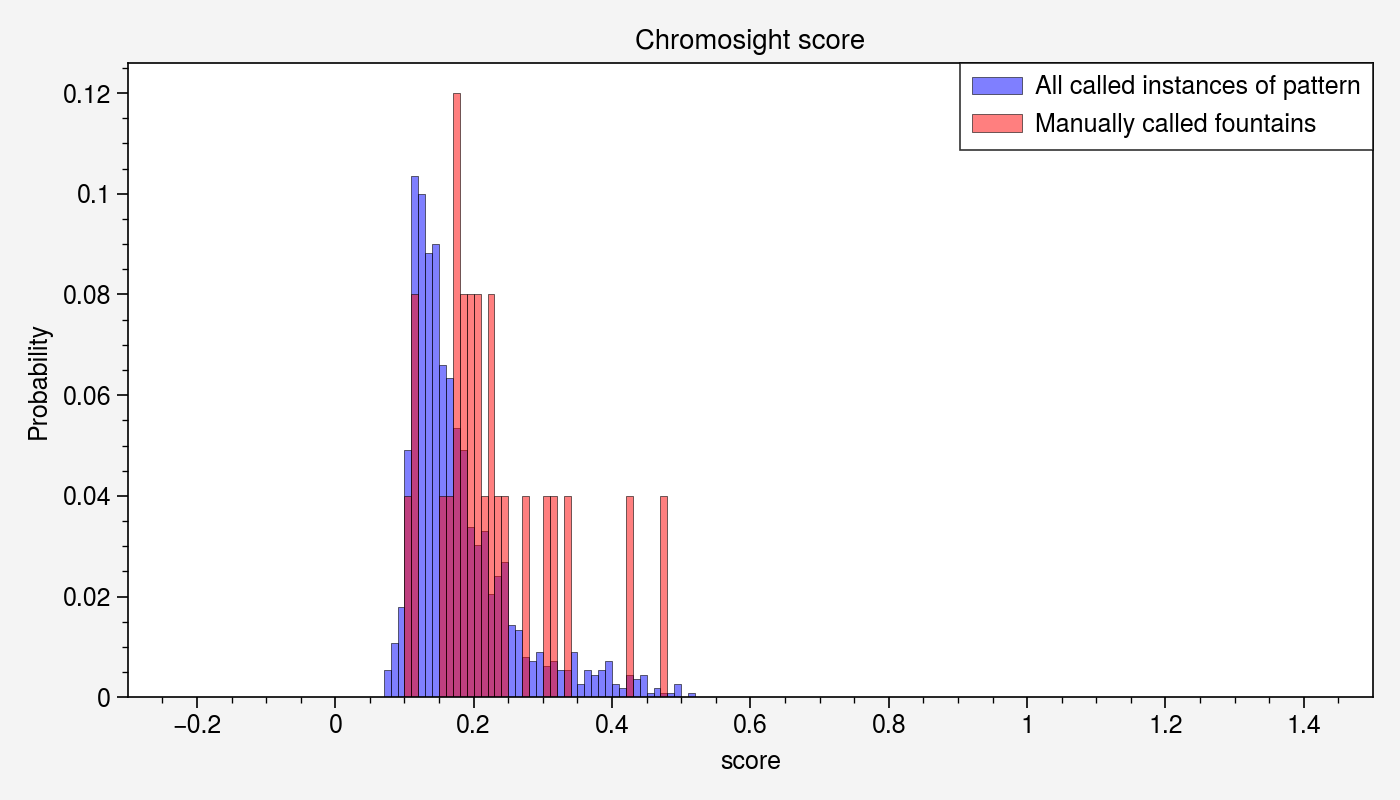

In [154]:
value = "score"
title = "Chromosight score"

plt.figure(figsize=[7, 4])

sns.histplot(df[value], 
             color='blue', alpha=0.5, stat='probability',
             bins=np.arange(-0.3, 1.5, 0.01), label='All called instances of pattern')

sns.histplot(df_confirmed[value+"_"], 
             color='red', alpha=0.5, stat='probability',
             bins=np.arange(-0.3, 1.5, 0.01), label='Manually called fountains')
plt.xlim(-0.3, 1.5)

plt.title(title)
plt.legend()
plt.tight_layout()